In [1]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt

In [16]:
def update_lambda(S, lambda_bar, delta, arm, lambda_, driver) :
    if S[driver][arm] <= 1 :
        lambda_[driver][arm] = 1
    else :
        lambda_[driver][arm] = (2 * lambda_bar[driver][arm] * math.log(delta / 2, 10) / S[driver][arm] )**0.5 + ( 7 * math.log(2/delta, 10) ) / ( 3 * (S[driver][arm] - 1) )

def update_lambda_bar(loss_matrix, S, arm, lambda_bar) :
    if S[driver][arm] <= 1 :
        lambda_bar[driver][arm] = 0
    else :
        for i in range(int(S[driver][arm])-1) :
            lambda_bar[driver][arm] += ((loss_matrix[driver][i][arm] - loss_matrix[driver][int(S[driver][arm]-1)][arm])**2)/(S[driver][arm]*(S[driver][arm]-1))


def update_mu_bar(S, arm, t, driver, loss_matrix, mu_bar) :
    S[driver][arm] += 1
    loss_sum = 0
    for i in range(t+1) :
        loss_sum += loss_matrix[driver][i][arm]
    mu_bar[driver][arm] = loss_sum/S[driver][arm]
    
    
def select_route(driver, mu_bar, lambda_) :
    temp = mu_bar[driver]-lambda_[driver]
    if len(np.unique(temp)) == 1:
        return random.randrange(3)
    if len(np.unique(temp)) == 2:
        if temp[0] == temp[1] :
            return random.randrange(2)
        if temp[0] == temp[2] :
            if random.randrange(2) == 0 :
                return 0
            return 1
        if temp[1] == temp[2] :
            return random.randrange(2)+1
    return list(temp).index(min(temp))

def loss_cul(human_acu, K) : #依據之前討論的loss function寫死
    loss_feeback = [0 for i in range(K)]
    for i in range(len(human_acu)) :   
        if i == 0 : 
            loss_feeback[i] = human_acu[i] * 2
        elif i == 1 :
            loss_feeback[i] = human_acu[i] + 1
        elif i == 2 :
            loss_feeback[i] = human_acu[i]**2
    return loss_feeback

def update_loss_matrix(driver, t, arm, loss) :
    loss_matrix[driver][t][arm] = loss

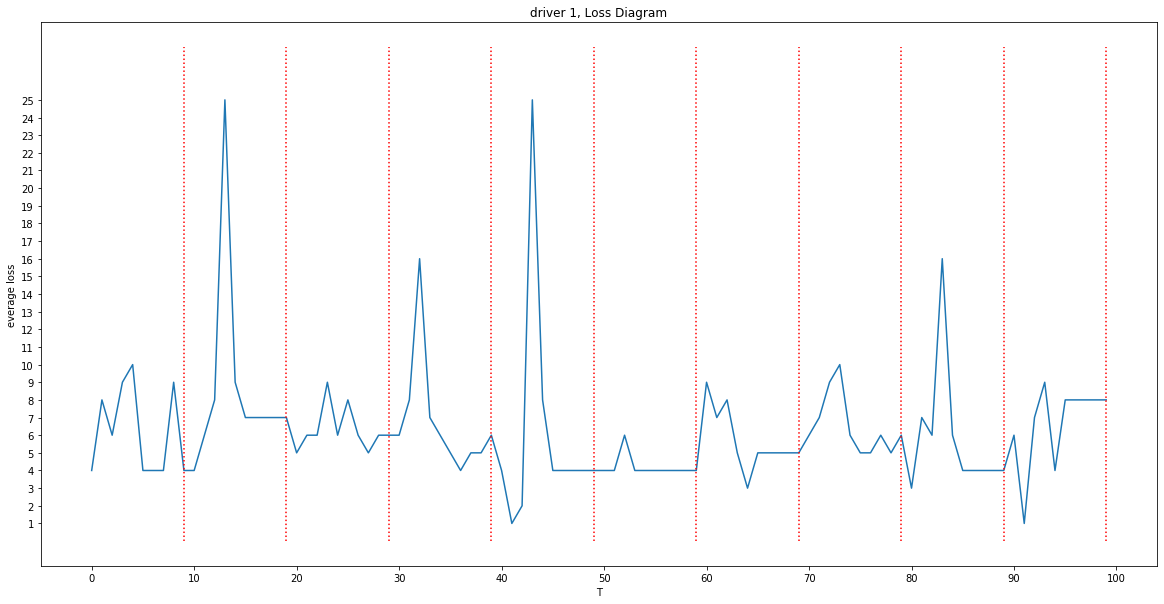

In [65]:
# parameters
drivers = 8 
K = 3 #amount of route      
# B_set = [i for i in range(10,11)] # each set has B steps, replace B with different value 圖一使用陣列B
# B_set = [10] 圖二三使用純量B
T = 100 # total steps
delta = 7 #parameter in in berstein inequality
#for diagram
picture_show = []
trend = []# record diagram's y-axis value

#main funciton
for B in B_set :
    rounds = T//B #cut total steps into 'rounds' sets with B steps 
    remain_step = T - rounds*B
    drivers_cost = np.zeros((drivers, T)) #record all lose for every driver
    for i in range(rounds) :  
        S = np.zeros((drivers, K)) # record how many times route was selected
        mu_bar = np.zeros((drivers, K)) 
        lambda_bar = np.zeros((drivers, K))
        lambda_ = np.ones((drivers, K))
        loss_matrix = np.zeros((drivers, B, K)) #each driver has personal loss matrix
        temp_record = [0 for i in range(drivers)]#record driver's choice  
        for j in range(B) :
            human_acu = [0 for i in range(K)]
            for driver in range(drivers) :
                route = select_route(driver, mu_bar, lambda_)
                temp_record[driver] = route
                human_acu[route] += 1
            loss_feeback = loss_cul(human_acu, K)
            picture_show.append(sum(loss_feeback))
            for driver in range(drivers) :
                drivers_cost[driver][i*B + j] = loss_feeback[temp_record[driver]] 
                update_loss_matrix(driver, j, temp_record[driver], loss_feeback[temp_record[driver]])
                update_mu_bar(S, temp_record[driver], j, driver, loss_matrix, mu_bar)
                update_lambda_bar(loss_matrix, S, temp_record[driver], lambda_bar)
                update_lambda(S, lambda_bar, delta, temp_record[driver], lambda_, driver)
        
    S = np.zeros((drivers, K))
    mu_bar = np.zeros((drivers, K)) 
    lambda_bar = np.zeros((drivers, K))
    lambda_ = np.ones((drivers, K))
    loss_matrix = np.zeros((drivers, B, K))
    temp_record = [0 for i in range(drivers)]
    for j in range(remain_step) :
        human_acu = [0 for i in range(K)]
        for driver in range(drivers) :
            route = select_route(driver, mu_bar, lambda_)
            temp_record[driver] = route
            human_acu[route] += 1
        loss_feeback = loss_cul(human_acu, K)
        picture_show.append(sum(loss_feeback))
        for driver in range(drivers) :
            drivers_cost[driver][i*B + j] = loss_feeback[temp_record[driver]] 
            update_loss_matrix(driver, j, temp_record[driver], loss_feeback[temp_record[driver]])
            update_mu_bar(S, temp_record[driver], j, driver, loss_matrix, mu_bar)
            update_lambda_bar(loss_matrix, S, temp_record[driver], lambda_bar)
            update_lambda(S, lambda_bar, delta, temp_record[driver], lambda_, driver)
    trend.append(sum(sum(drivers_cost)) / drivers)
    
#圖一
# plt.figure(figsize=(20, 10))    
# plt.plot(range(1, 101), trend)
# plt.xticks(range(0, 101, 10))
# plt.title("Relation between B and average loss")
# plt.xlabel('B')
# plt.ylabel('everage loss')
# plt.show()
#這裡的y軸是"所有人100步總損失"的平均, x軸是B的數值

#圖二
# plt.figure(figsize=(20,10))
# plt.plot(range(T), sum(drivers_cost)/drivers)
# for i in range(1, rounds+1) :
#     plt.plot([i*B-1,i*B-1], [0, max(sum(drivers_cost)/drivers)], color='red', linestyle=':') 
# plt.xlabel('T')
# plt.ylabel('everage loss')
# plt.yticks(range(int(min(sum(drivers_cost)/drivers)), int(max(sum(drivers_cost)/drivers))+1, 1))
# plt.xticks(range(0, T+1, 10))
# plt.title("B="+str(B)+", Average Loss Diagram")
# plt.show()
#y軸是第t步所有人的平均損失，x軸是t的數值(from 0 to T)

#圖三
driver = 1 #可以自行設定要觀察的駕駛(0 ~ drivers-1)
plt.figure(figsize=(20,10))
plt.plot(range(T), drivers_cost[driver])
for i in range(1, rounds+1) :
    plt.plot([i*B-1,i*B-1], [0, max(sum(drivers_cost)/drivers)], color='red', linestyle=':') 
plt.xlabel('T')
plt.ylabel('everage loss')
plt.yticks(range(int(min(drivers_cost[driver])), int(max(drivers_cost[driver]))+1, 1))
plt.xticks(range(0, T+1, 10))
plt.title("driver "+str(driver)+", Loss Diagram")
plt.show()
#y軸是第t步你選定的driver的損失，x軸是t的數值(from 0 to T)